In [92]:
import pandas as pd
from darts import TimeSeries
from darts.models import Prophet
from darts import TimeSeries
import matplotlib as plt
from darts.models import RegressionModel
import numpy as np


In [93]:
df_features = pd.read_csv('../data/features.csv')
df_sales = pd.read_csv('../data/sales.csv')
df_stores = pd.read_csv('../data/stores.csv')
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y')
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d/%m/%Y')
df_features = df_features.rename(columns={'IsHoliday': 'IsHolidayFeatures'})
df_combined = pd.merge(df_sales, df_stores, on='Store', how='left')
df_final = pd.merge(df_combined, df_features, on=['Store', 'Date'], how='left')
df_final['week'] = df_final['Date'].dt.isocalendar().week
df_final['month'] = df_final['Date'].dt.month
df_final['day'] = df_final['Date'].dt.day
df_final['original_date'] = df_final['Date']
df_final.set_index('Date', inplace=True)

In [94]:
target = None
past_covariates = None

for store in range(1, 30):
    for dept in range(1, 10):
        df_filtered = df_final[(df_final['Store'] == store) & (df_final['Dept'] == dept)]
        
        if df_filtered.empty:
            continue
        series = TimeSeries.from_dataframe(df_filtered, value_cols=['Weekly_Sales', 'Dept', 'Store', 'IsHoliday'])
        series = series.with_static_covariates(pd.Series({'store_id': store, 'dept_id': dept}))
        current_target = series['Weekly_Sales']
        current_past_cov_dept = series['Dept']
        current_past_cov_store = series['Store']
        current_past_cov_holiday = series['IsHoliday']
        current_past_covariates = current_past_cov_dept.stack(current_past_cov_store)
        current_past_covariates.stack(current_past_cov_holiday)
        target = current_target if target is None else target.stack(current_target)
        past_covariates = current_past_covariates if past_covariates is None else past_covariates.stack(current_past_covariates)



In [95]:
target_train=target[:80]
target_test = target[80:144]

In [96]:
cov_train=past_covariates[:80]
cov_test = past_covariates[80:144]

In [97]:

regr_model = RegressionModel(lags=30,
                            lags_past_covariates=30,
                            output_chunk_length=40
                            )
test = regr_model.fit(series=target_train,
            past_covariates=cov_train)
future = regr_model.predict(40, series =target, past_covariates=cov_test)


In [100]:
test1 = future.sum(axis=1)
test2 = target.sum(axis=1)

<Axes: xlabel='Date'>

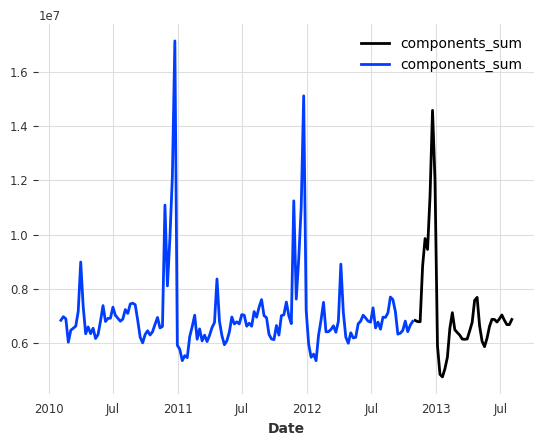

In [101]:
test1.plot()
test2.plot()
